#import module

In [1]:
import math
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from einops.layers.torch import Rearrange
from einops import rearrange

#Setting Seed value

In [2]:
# シード値の設定
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

#Masked AutoEncoder

##Multi-Head Attention

In [3]:
# Multi-Head Attentionの実装
class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．埋め込み次元数と一致する．
        heads : int
            ヘッドの数．
        dim_head : int
            各ヘッドのデータの次元数．
        dropout : float
            Dropoutの確率(default=0.)．
        """
        super().__init__()

        self.dim = dim
        self.dim_head = dim_head
        inner_dim = dim_head * heads  # ヘッドに分割する前のQ, K, Vの次元数．self.dimと異なっても良い．
        project_out = not (heads == 1 and dim_head == dim)  # headsが1，dim_headがdimと等しければ通常のSelf-Attention

        self.heads = heads
        self.scale = math.sqrt(dim_head)  # ソフトマックス関数を適用する前のスケーリング係数(dim_k)

        self.attend = nn.Softmax(dim=-1)  # アテンションスコアの算出に利用するソフトマックス関数
        self.dropout = nn.Dropout(dropout)

        # Q, K, Vに変換するための全結合層
        self.to_q = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_k = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_v = nn.Linear(in_features=dim, out_features=inner_dim)

        # dim != inner_dimなら線形層を入れる，そうでなければそのまま出力
        self.to_out = nn.Sequential(
            nn.Linear(in_features=inner_dim, out_features=dim),
            nn.Dropout(dropout),
        ) if project_out else nn.Identity()

    def forward(self, x):
        """
        B: バッチサイズ
        N: 系列長
        D: データの次元数(dim)
        """
        B, N, D = x.size()

        # 入力データをQ, K, Vに変換する
        # (B, N, dim) -> (B, N, inner_dim)
        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)

        # Q, K, Vをヘッドに分割する
        # (B, N, inner_dim) -> (B, heads, N, dim_head)
        q = rearrange(q, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        k = rearrange(k, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        v = rearrange(v, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)

        # QK^T / sqrt(d_k)を計算する
        # (B, heads, N, dim_head) x (B, heads, dim_head, N) -> (B, heads, N, N)
        dots = torch.matmul(q, k.transpose(-2, -1)) / self.scale

        # ソフトマックス関数でスコアを算出し，Dropoutをする
        attn = self.attend(dots)
        attn = self.dropout(attn)

        # softmax(QK^T / sqrt(d_k))Vを計算する
        # (B, heads, N, N) x (B, heads, N, dim_head) -> (B, heads, N, dim_head)
        out = torch.matmul(attn ,v)

        # もとの形に戻す
        # (B, heads, N, dim_head) -> (B, N, dim)
        out = rearrange(out, "b h n d -> b n (h d)", h=self.heads, d=self.dim_head)

        # 次元が違っていればもとに戻して出力
        # 表現の可視化のためにattention mapも返すようにしておく
        return self.to_out(out), attn

In [4]:
attn = Attention(384, 12, 32, 0.)
x = torch.rand(4, 9, 384)  # (B, N, D)
attn(x)[0].shape

torch.Size([4, 9, 384])

#Feed-Forward Network

In [5]:
# Feed-Forward Networkの実装
class FFN(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．
        hidden_dim : int
            隠れ層の次元．
        dropout : float
            各全結合層の後のDropoutの確率(default=0.)．
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=dim, out_features=hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=hidden_dim, out_features=dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        """
        (B, D) -> (B, D)
        B: バッチサイズ
        D: 次元数
        """
        return self.net(x)

In [6]:
ffn = FFN(384, 768, 0.)
x = torch.rand(4, 9, 384)  # (B, N, D)
ffn(x).shape

torch.Size([4, 9, 384])

#Transformer BlocK

In [7]:
class Block(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout):
        """
        TransformerのEncoder Blockの実装．

        Arguments
        ---------
        dim : int
            埋め込みされた次元数．PatchEmbedのembed_dimと同じ値．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        dropout : float
            Droptou層の確率p．
        """
        super().__init__()

        self.attn_ln = nn.LayerNorm(dim)  # Attention前のLayerNorm
        self.attn = Attention(dim, heads, dim_head, dropout)
        self.ffn_ln = nn.LayerNorm(dim)  # FFN前のLayerNorm
        self.ffn = FFN(dim, mlp_dim, dropout)

    def forward(self, x, return_attn=False):
        """
        x: (B, N, dim)
        B: バッチサイズ
        N: 系列長
        dim: 埋め込み次元
        """
        y, attn = self.attn(self.attn_ln(x))
        if return_attn:  # attention mapを返す（attention mapの可視化に利用）
            return attn
        x = y + x
        out = self.ffn(self.ffn_ln(x)) + x

        return out

In [8]:
block = Block(384, 12, 32, 384, 0.)
x = torch.rand(4, 9, 384)  # (B, N, D)
block(x).shape

torch.Size([4, 9, 384])

#Patch Embedding

In [9]:
# Patch Embeddingの実装
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        """
        入力画像をパッチごとに埋め込むための層．

        Arguments
        ---------
        image_size : Tuple[int]
            入力画像のサイズ．
        patch_size : Tuple[int]
            各パッチのサイズ．
        in_channels : int
            入力画像のチャネル数．
        embed_dim : int
            埋め込み後の次元数．
        """
        super().__init__()

        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, "パッチサイズは，入力画像のサイズを割り切れる必要があります．"

        num_patches = (image_height // patch_height) * (image_width // patch_width)  # パッチの数
        patch_dim = in_channels * patch_height * patch_width  # 各パッチを平坦化したときの次元数

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_height, p2=patch_width),  # 画像をパッチに分割して平坦化
            nn.Linear(in_features=patch_dim, out_features=embed_dim),  # 埋め込みを行う
        )

    def forward(self, x):
        """
        B: バッチサイズ
        C: 入力画像のチャネル数
        H: 入力画像の高さ
        W: 入力画像の幅
        """
        return self.to_patch_embedding(x)  # (B, C, H, W) -> (B, num_patches, embed_dim)

In [10]:
patch_emb = PatchEmbedding((240, 240), (80, 80), 1, 384)
x = torch.rand((4, 1, 240, 240))  # (B, C, H, W)
patch_emb(x).shape

torch.Size([4, 9, 384])

#Masked AutoEncoder

## Random Mask

### For 3*3 patches

In [11]:
def random_indexes(size):
    """
    パッチをランダムに並べ替えるためのindexを生成する関数．

    Argument
    --------
    size : int
        入力されるパッチの数（系列長Nと同じ値）．
    """
    original_indexes = np.arange(size)  # 0からsizeまでを並べた配列を作成, No shuffle
    #idx = np.random.randint(0,9)
    #forward_indexes = np.delete(original_indexes,idx) #delete element whose index is idx
    #forward_indexes = np.append(forward_indexes,idx)
    #np.random.shuffle(original_indexes)  # 生成した配列をシャッフルすることで，パッチの順番をランダムに決定
    #backward_indexes = np.argsort(original_indexes)  # 並べ替えたパッチをもとの順番に戻すためのidx

    return  original_indexes,original_indexes#,backward_indexes #forward_indexes,

### For 9*9patches

In [12]:
def random_indexes(size):
    """
    パッチをランダムに並べ替えるためのindexを生成する関数．

    Argument
    --------
    size : int
        入力されるパッチの数（系列長Nと同じ値）．
    """
    original_indexes = np.arange(size)  # 0からsizeまでを並べた配列を作成, No shuffle
    #idx = np.random.randint(0,9)
    mask_indexes = []
    for i in range(6,9):
        for j in range(3):
            mask_indexes.append(9*i+6+j)
    forward_indexes = np.delete(original_indexes,mask_indexes) #delete element whose index is idx
    forward_indexes = np.append(forward_indexes,mask_indexes)
    #np.random.shuffle(original_indexes)  # 生成した配列をシャッフルすることで，パッチの順番をランダムに決定
    backward_indexes = np.argsort(forward_indexes)  # 並べ替えたパッチをもとの順番に戻すためのidx

    return  forward_indexes, backward_indexes#,backward_indexes #forward_indexes,

## For 27*27 patches

In [11]:
def random_indexes(size):
    """
    パッチをランダムに並べ替えるためのindexを生成する関数．

    Argument
    --------
    size : int
        入力されるパッチの数（系列長Nと同じ値）．
    """
    original_indexes = np.arange(size)  # 0からsizeまでを並べた配列を作成, No shuffle
    #idx = np.random.randint(0,9)
    mask_indexes = []
    for i in range(18,27):
        for j in range(9):
            mask_indexes.append(27*i+18+j)
    forward_indexes = np.delete(original_indexes,mask_indexes) #delete element whose index is idx
    forward_indexes = np.append(forward_indexes,mask_indexes)
    #np.random.shuffle(original_indexes)  # 生成した配列をシャッフルすることで，パッチの順番をランダムに決定
    backward_indexes = np.argsort(forward_indexes)  # 並べ替えたパッチをもとの順番に戻すためのidx

    return  forward_indexes, backward_indexes#,backward_indexes #forward_indexes,

In [12]:
x = np.random.randn((27*27))
forward_indexes, backward_indexes = random_indexes(x.shape[0])

print(f"original array: \n{x}")
print(f"forward indexes: \n{forward_indexes}\n{x[forward_indexes]}")  # ランダムに並べ替える
print(f"backward indexes: \n{backward_indexes}\n{x[forward_indexes][backward_indexes]}")  # 並べ替えた後にもとに戻す

original array: 
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004 -0.46341769 -0.46572975
  0.24196227 -1.91328024 -1.72491783 -0.56228753 -1.01283112  0.31424733
 -0.90802408 -1.4123037   1.46564877 -0.2257763   0.0675282  -1.42474819
 -0.54438272  0.11092259 -1.15099358  0.37569802 -0.60063869 -0.29169375
 -0.60170661  1.85227818 -0.01349722 -1.05771093  0.82254491 -1.22084365
  0.2088636  -1.95967012 -1.32818605  0.19686124  0.73846658  0.17136828
 -0.11564828 -0.3011037  -1.47852199 -0.71984421 -0.46063877  1.05712223
  0.34361829 -1.76304016  0.32408397 -0.38508228 -0.676922    0.61167629
  1.03099952  0.93128012 -0.83921752 -0.30921238  0.33126343  0.97554513
 -0.47917424 -0.18565898 -1.10633497 -1.19620662  0.81252582  1.35624003
 -0.07201012  1.0035329   0.36163603 -0.64511975  0.36139561  1.53803657
 -0.03582604  1.56464366 -2.6197451   0.8219025   0.08704707 -0.29900735
  0.09176078 -1.98756891 -0.219671

#For patched imgs

In [13]:
def take_indexes(sequences, indexes):
    """
    パッチを並べ替えるための関数．

    Argument
    --------
    sequences : torch.Tensor
        入力画像をパッチ分割したデータ．(B, N, dim)の形状をしている．
    indexes : np.ndarray
        並べ替えるために利用するindex．
        random_indexesで生成したforward_indexesかbackward_indexesが入ることが想定されている．
    """
    return torch.gather(sequences, dim=1, index=indexes.unsqueeze(2).repeat(1, 1, sequences.shape[-1]))

#Patch Shuffle

In [14]:
class PatchShuffle(nn.Module):
    def __init__(self, ratio):
        # ratio: Encoderに入力しないパッチの割合
        super().__init__()
        self.ratio = ratio

    def forward(self, patches):
        """
        B: バッチサイズ
        N: 系列長（＝パッチの数）
        dim: 次元数（＝埋め込みの次元数）
        """
        B, N, dim = patches.shape
        remain_N = int(N * (1 - self.ratio))  # Encoderに入力するパッチの数

        indexes = [random_indexes(N) for _ in range(B)]  # バッチごとに異なる順番のindexを作る
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).T.to(patches.device)  # バッチを並べ替えるときのidx (B, N)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).T.to(patches.device)  # 並べ替えたパッチをもとの順番に戻すためのidx  (B, N)

        patches = take_indexes(patches, forward_indexes)  # パッチを並べ替える
        patches = patches[:, :remain_N, :]  # Encoderに入力するパッチを抽出
        #print(patches.shape)

        return patches, forward_indexes, backward_indexes

In [15]:
x = torch.rand((4, 27*27, 2))  # (B, N, dim) 見やすいように小さい行列にしている
patch_shuffle = PatchShuffle(ratio=1/9)
in_patches, forward_idx, backward_idx = patch_shuffle(x)

print(f"original data: shape {x.shape} \n")
print(f"encoder input data: shape {in_patches.shape} \n")

original data: shape torch.Size([4, 729, 2]) 

encoder input data: shape torch.Size([4, 648, 2]) 



##Encoder

In [16]:
class MAE_Encoder(torch.nn.Module):
    def __init__(self, image_size=[243, 243], patch_size=[81, 81], emb_dim=192, num_layer=12,
                 heads=3, dim_head=64, mlp_dim=192, mask_ratio=1/9, dropout=0.):
        """
        Arguments
        ---------

        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        num_layer : int
            Encoderに含まれるBlockの数．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        mask_ratio : float
            入力パッチのマスクする割合．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()
        img_height, img_width = image_size
        patch_height, patch_width = patch_size
        num_patches = (img_height // patch_height) * (img_width // patch_width)

        self.cls_token = torch.nn.Parameter(torch.randn(1, 1, emb_dim))  # class tokenの初期化
        self.pos_embedding = torch.nn.Parameter(torch.randn(1, num_patches, emb_dim))  # positional embedding（学習可能にしている）
        self.shuffle = PatchShuffle(mask_ratio)

        # 入力画像をパッチに分割する
        self.patchify = PatchEmbedding(image_size, patch_size, 1, emb_dim) #Gray scale img

        # Encoder（Blockを重ねる）
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])

        self.layer_norm = nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        torch.nn.init.normal_(self.cls_token, std=0.02)
        torch.nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, img):
        # 1. 入力画像をパッチに分割して，positional embeddingする
        patches = self.patchify(img)
        patches = patches + self.pos_embedding

        # 2. 分割したパッチをランダムに並べ替えて，必要なパッチのみ得る
        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        # class tokenを結合
        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)

        # 3. Encoderで入力データを処理する
        features = self.layer_norm(self.transformer(patches))

        return features, backward_indexes

#Decoder

In [17]:
class MAE_Decoder(nn.Module):
    def __init__(self, image_size=[243, 243], patch_size=[9, 9], emb_dim=192, num_layer=4,
                 heads=3, dim_head=64, mlp_dim=192, dropout=0.):
        """
        Arguments
        ---------

        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        num_layer : int
            Decoderに含まれるBlockの数．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()
        img_height, img_width = image_size
        patch_height, patch_width = patch_size
        num_patches = (img_height // patch_height) * (img_width // patch_width)

        self.mask_token = torch.nn.Parameter(torch.rand(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.rand(1, num_patches+1, emb_dim))

        # Decoder(Blockを重ねる）
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])

        # 埋め込みされた表現から画像を復元するためのhead
        self.head = torch.nn.Linear(emb_dim, patch_height * patch_width)
        # (B, N, dim)から(B, C, H, W)にreshapeするためのインスタンス
        self.patch2img = Rearrange("b (h w) (c p1 p2) -> b c (h p1) (w p2)", p1=patch_height, p2=patch_width, h=img_height // patch_height)

        self.init_weight()

    def init_weight(self):
        torch.nn.init.normal_(self.mask_token, std=0.02)
        torch.nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, features, backward_indexes):
        # 系列長
        T = features.shape[1]

        # class tokenがある分backward_indexesの最初に0を追加する
        # .toはデバイスの変更でよく利用するが，tensorを渡すことでdtypeを変えることができる
        backward_indexes = torch.cat([torch.zeros(backward_indexes.shape[0], 1).to(backward_indexes), backward_indexes+1], dim=1)

        # 1. mask_tokenを結合して並べ替える．
        # (B, N*(1-mask_ratio)+1, dim) -> (B, N+1, dim)
        features = torch.cat([features, self.mask_token.repeat(features.shape[0], backward_indexes.shape[1] - features.shape[1], 1)], dim=1)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = self.transformer(features)

        # class tokenを除去する
        # (B, N+1, dim) -> (B, N, dim)
        features = features[:, 1:, :]

        # 2. 画像を再構成する．
        # (B, N, dim) -> (B, N, 3 * patch_height * patch_width)
        patches = self.head(features)

        # MAEではマスクした部分でのみ損失関数を計算するため，maskも一緒に返す
        mask = torch.zeros_like(patches)
        mask[:, T-1:] = 1  # cls tokenを含めていた分ずらしている
        mask = take_indexes(mask, backward_indexes[:, 1:] - 1)

        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

#Masked Autoencoder

In [18]:
class MAE_ViT(torch.nn.Module):
    def __init__(self, image_size=[243, 243], patch_size=[81, 81], emb_dim=192,
                 enc_layers=12, enc_heads=3, enc_dim_head=64, enc_mlp_dim=768,
                 dec_layers=4, dec_heads=3, dec_dim_head=64, dec_mlp_dim=768,
                 mask_ratio=1/9, dropout=0.):
        """
        Arguments
        ---------
        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        {enc/dec}_layers : int
            Encoder / Decoderに含まれるBlockの数．
        {enc/dec}_heads : int
            Encoder / DecoderのMulti-Head Attentionのヘッドの数．
        {enc/dec}_dim_head : int
            Encoder / DecoderのMulti-Head Attentionの各ヘッドの次元数．
        {enc/dec}_mlp_dim : int
            Encoder / DecoderのFeed-Forward Networkの隠れ層の次元数．
        mask_ratio : float
            入力パッチのマスクする割合．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, enc_layers,
                                   enc_heads, enc_dim_head, enc_mlp_dim, mask_ratio, dropout)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, dec_layers,
                                   dec_heads, dec_dim_head, dec_mlp_dim, dropout)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        rec_img, mask = self.decoder(features, backward_indexes)
        return rec_img, mask

    def get_last_selfattention(self, x):
        patches = self.encoder.patchify(x)
        patches = patches + self.encoder.pos_embedding

        patches = torch.cat([self.encoder.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        for i, block in enumerate(self.encoder.transformer):
            if i < len(self.encoder.transformer) - 1:
                patches = block(patches)
            else:
                return block(patches, return_attn=True)

#Cosine Scheduler

In [19]:
# cosine scheduler
class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr

#Learning Rate Scheduler

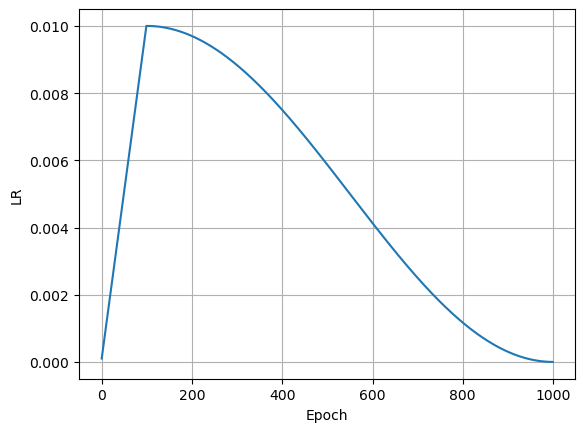

In [20]:
import matplotlib.pyplot as plt

scheduler = CosineScheduler(epochs=1000, lr=0.01,warmup_length=100)
x = np.arange(1000)
plt.plot(x, [scheduler(epoch) for epoch in x])
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)

plt.show()

In [21]:
def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

#Config

In [38]:
# ハイパーパラメータの設定

config = {
    "image_size": [243, 243],
    "patch_size": [9, 9],
    "emb_dim": 384,#192,
    "enc_layers": 12, #12
    "enc_heads": 6,#3
    "enc_dim_head": 64,#64
    "enc_mlp_dim": 384,#192,
    "dec_layers": 4,
    "dec_heads": 6,#3
    "dec_dim_head": 64,
    "dec_mlp_dim":384,#192,
    "mask_ratio": 1/9,
    "dropout": 0.
}
'''
config = {
    "image_size": [243, 243],
    "patch_size": [9, 9],
    "emb_dim": 81,#192,
    "enc_layers": 12, #12
    "enc_heads": 3,#3
    "enc_dim_head": 27,#64
    "enc_mlp_dim": 81,#192,
    "dec_layers": 4,
    "dec_heads": 3,#3
    "dec_dim_head": 27,
    "dec_mlp_dim":81,#192,
    "mask_ratio": 1/9,
    "dropout": 0.
}
'''

'\nconfig = {\n    "image_size": [243, 243],\n    "patch_size": [9, 9],\n    "emb_dim": 81,#192,\n    "enc_layers": 12, #12\n    "enc_heads": 3,#3\n    "enc_dim_head": 27,#64\n    "enc_mlp_dim": 81,#192,\n    "dec_layers": 4,\n    "dec_heads": 3,#3\n    "dec_dim_head": 27,\n    "dec_mlp_dim":81,#192,\n    "mask_ratio": 1/9,\n    "dropout": 0.\n}\n'

In [39]:
# モデルの定義
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = MAE_ViT(**config).to(device)

epochs = 2500
lr = 0.1
warmup_length = 100
batch_size = 1
step_count = 0
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.05)
scheduler = CosineScheduler(epochs, lr, warmup_length=warmup_length)

cuda


#load data

In [24]:
import pandas as pd
import cv2
from sklearn.utils import shuffle
"""
SRC_TRAIN = "/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20230302/dataset/train_vit_new2old.csv"
SRC_TEST = "/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20230302/dataset/test_vit_new2old.csv"
"""
SRC_TRAIN = r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\ViT\MAE_spatterframe_estimation\train.csv"
SRC_TEST = r"C:\Users\Furukawa\Documents\TechAssistant\dataset\csv\ViT\MAE_spatterframe_estimation\test.csv"

SCALE_X = 243/240
SCALE_Y = 243/240
IMG_SIZE = 240

class Dataset():
  def __init__(self,scale_x = SCALE_X,scale_y = SCALE_Y,img_size=IMG_SIZE,src_train=SRC_TRAIN,src_test=SRC_TEST):
    self.src_train = src_train
    self.src_test = src_test
    self.scale_x = scale_x
    self.scale_y = scale_y
    self.img_size = img_size

    data_train,label_train,data_valid,label_valid,data_test,label_test = self.load_data()

    img_train, label_train = self.url2img(data_train,label_train)
    img_valid, label_valid = self.url2img(data_valid,label_valid)
    img_test, label_test = self.url2img(data_test,label_test)

    #when calculating (dividing process) the type have to be float
    image_train = img_train.astype("float32")
    image_valid = img_valid.astype("float32")
    image_test = img_test.astype("float32")

    #when training, it is convenient if the values are normalized
    #-1 ~ 1
    img_train = img_train/255
    img_train = 2*img_train - np.ones(img_train.shape)
    img_valid = img_valid/255
    img_valid = 2*img_valid - np.ones(img_valid.shape)
    img_test = img_test/255
    img_test = 2*img_test - np.ones(img_test.shape)

    # converting data to float32, especially float32
    self.img_train =np.expand_dims(np.asarray(img_train).astype(np.float32),1)
    self.label_train = np.asarray(label_train).astype(np.int32)
    self.img_valid = np.expand_dims(np.asarray(img_valid).astype(np.float32),1)
    self.label_valid = np.asarray(label_valid).astype(np.int32)
    self.img_test = np.expand_dims(np.asarray(img_test).astype(np.float32),1)
    self.label_test = np.asarray(label_test).astype(np.int32)

  def load_data(self):
    file_train = pd.read_csv(filepath_or_buffer = self.src_train)
    value_train = file_train.values
    file_test = pd.read_csv(filepath_or_buffer = self.src_test)
    value_test = file_test.values

    print(value_test[:5])
    ## ////////// テスト用とトレーニング用でデータをシャッフルする //////////////
    #for 2D shuffle
    value_train = shuffle(value_train,random_state=42) #random_state = integer ; fix randomness with shuffling
    value_test = shuffle(value_test,random_state=42)

    num_train = int(value_train.shape[0]*0.95)
    #DATA,LABEL
    #train,val
    data_train = value_train[:num_train,1:]
    label_train =  value_train[:num_train,0]
    data_valid = value_train[num_train:,1:]
    label_valid =  value_train[num_train:,0] #value_train.shape[0]//2
    #test
    data_test = value_test[:,1:]
    label_test = value_test[:,0]

    #check the distribution
    count_test = 0
    count_train = 0
    count_valid = 0
    for i in range(len(label_test)):
      if label_test[i] == 1:
        count_test += 1

    for i in range(len(label_train)):
      if label_train[i] == 1:
        count_train += 1
    
    for i in range(len(label_valid)):
      if label_train[i] == 1:
        count_valid += 1

    print('spatter label : : train : {}/{}, valid : {}/{} test : {}/{}'.format(count_train,len(label_train),count_valid,len(label_valid),count_test,len(label_test)))
    return data_train,label_train,data_valid,label_valid,data_test,label_test


  def url2img(self,data,label):
    image_data = np.zeros((len(data),int(self.img_size*self.scale_x),int(self.img_size*self.scale_y)))
    label_revised = []
    size = (int(self.img_size*self.scale_x),int(self.img_size*self.scale_y))
    for i,[name] in enumerate(data):
      if i % 100 == 99:
        print((len(data),i))
      #print(name)
      img=cv2.imread(name)
      if np.any(img) == None:
        continue
      elif img[0,0,0] != None :
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray,size,interpolation = cv2.INTER_AREA)
        image_data[i] = gray
        label_revised.append(label[i])
    print("length of dataset is ",len(label_revised))
    print("image data shape : ",image_data.shape)
    imagedata = image_data[:len(label_revised)]
    #imagedata = np.expand_dims(imagedata,1) #add color channel 1
    return imagedata,label_revised

In [25]:
dataset = Dataset(scale_x = SCALE_X,scale_y = SCALE_Y,img_size=IMG_SIZE,src_train=SRC_TRAIN,src_test=SRC_TEST)
img_train = dataset.img_train
label_train = dataset.label_train
img_valid = dataset.img_valid
label_valid = dataset.label_valid
img_test = dataset.img_test
label_test = dataset.label_test

[[1
  'C:\\Users\\Furukawa\\Documents\\TechAssistant\\dataset\\imgs\\20220401\\2_2\\concat_MAE_spatterframe_estimation\\0055.jpg']
 [1
  'C:\\Users\\Furukawa\\Documents\\TechAssistant\\dataset\\imgs\\20220401\\3_1\\concat_MAE_spatterframe_estimation\\0315.jpg']
 [1
  'C:\\Users\\Furukawa\\Documents\\TechAssistant\\dataset\\imgs\\20220401\\3_1\\concat_MAE_spatterframe_estimation\\0909.jpg']
 [1
  'C:\\Users\\Furukawa\\Documents\\TechAssistant\\dataset\\imgs\\20220401\\3_2\\concat_MAE_spatterframe_estimation\\0463.jpg']
 [1
  'C:\\Users\\Furukawa\\Documents\\TechAssistant\\dataset\\imgs\\20220401\\3_2\\concat_MAE_spatterframe_estimation\\0540.jpg']]
spatter label : : train : 366/366, valid : 20/20 test : 34/34
(366, 99)
(366, 199)
(366, 299)
length of dataset is  366
image data shape :  (366, 243, 243)
length of dataset is  20
image data shape :  (20, 243, 243)
length of dataset is  34
image data shape :  (34, 243, 243)


#dataloader

In [40]:
train_dl = torch.utils.data.DataLoader(
    img_train,
    batch_size=batch_size,
)

valid_dl = torch.utils.data.DataLoader(
    img_valid,
    batch_size=batch_size,
)
test_dl = torch.utils.data.DataLoader(
    img_test,
    batch_size=34#batch_size,
)


In [41]:
count = 0
for x in train_dl:
    if count == 1:
        break
    print(x)
    count += 1
print(count)

tensor([[[[-0.9608, -0.9608, -0.9608,  ..., -0.9608, -0.9608, -0.9608],
          [-0.9608, -0.9608, -0.9608,  ..., -0.9608, -0.9608, -0.9608],
          [-0.9608, -0.9608, -0.9608,  ..., -0.9608, -0.9608, -0.9608],
          ...,
          [-0.9451, -0.9451, -0.9451,  ..., -0.9529, -0.9529, -0.9529],
          [-0.9451, -0.9451, -0.9451,  ..., -0.9529, -0.9529, -0.9529],
          [-0.9451, -0.9451, -0.9451,  ..., -0.9529, -0.9529, -0.9529]]]])
1


In [42]:
losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(epochs):
    # スケジューラで学習率を更新する
    new_lr = scheduler(epoch)
    set_lr(new_lr, optimizer)

    total_train_loss = 0.
    total_valid_loss = 0.

    # モデルの訓練
    for x in train_dl:
        step_count += 1
        model.train()
        x = x.to(device)

        rec_img, mask = model(x)
        train_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]
        train_loss.backward()

        if step_count % 8 == 0:  # 8イテレーションごとに更新することで，擬似的にバッチサイズを大きくしている
            optimizer.step()
            optimizer.zero_grad()

        total_train_loss += train_loss.item()
    losses.append(total_train_loss)

    # モデルの評価
    with torch.no_grad():
        for x in valid_dl:
            model.eval()

            with torch.no_grad():
                x = x.to(device)

                rec_img, mask = model(x)
                valid_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

                total_valid_loss += valid_loss.item()
    val_losses.append(total_valid_loss)


    print(f"Epoch[{epoch+1} / {epochs}] Train Loss: {total_train_loss/len(train_dl):.4f} Valid Loss: {total_valid_loss/len(valid_dl):.4f}")
    if epoch % 500 == 499:
        # モデルを保存しておく
        torch.save(model.state_dict(), r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\vit\mae_spatterframereconstruction_patch27_27_emb384_{epoch}.pth".format(epoch=epoch+1))

Epoch[1 / 2500] Train Loss: 0.2538 Valid Loss: 0.0590
Epoch[2 / 2500] Train Loss: 0.0966 Valid Loss: 0.0320
Epoch[3 / 2500] Train Loss: 0.1066 Valid Loss: 0.0389
Epoch[4 / 2500] Train Loss: 0.3197 Valid Loss: 2.3111
Epoch[5 / 2500] Train Loss: 10.2170 Valid Loss: 1.0218
Epoch[6 / 2500] Train Loss: 0.7155 Valid Loss: 0.1397
Epoch[7 / 2500] Train Loss: 0.1206 Valid Loss: 0.0877
Epoch[8 / 2500] Train Loss: 79.5117 Valid Loss: 142.8811
Epoch[9 / 2500] Train Loss: 44.4798 Valid Loss: 18.5471
Epoch[10 / 2500] Train Loss: 104.6327 Valid Loss: 102.1961
Epoch[11 / 2500] Train Loss: 19.9488 Valid Loss: 1.5363
Epoch[12 / 2500] Train Loss: 1.2412 Valid Loss: 0.3407
Epoch[13 / 2500] Train Loss: 0.2069 Valid Loss: 0.2175
Epoch[14 / 2500] Train Loss: 1975.7106 Valid Loss: 217.6886
Epoch[15 / 2500] Train Loss: 89.6940 Valid Loss: 23.5905
Epoch[16 / 2500] Train Loss: 3.7364 Valid Loss: 0.7403
Epoch[17 / 2500] Train Loss: 1.6496 Valid Loss: 1.8341
Epoch[18 / 2500] Train Loss: 5244.7247 Valid Loss: 761.6

C:\Users\Furukawa\AppData\Local\Temp\ipykernel_18004\3352678163.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


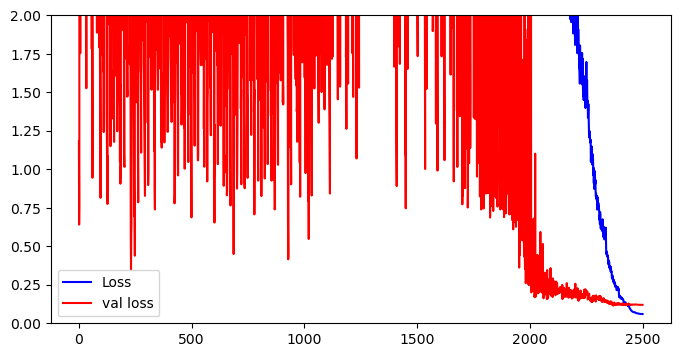

In [43]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(losses,color="b",label="Loss")
ax.plot(val_losses,color="r",label="val loss")
ax.set_ylim(0,2)
ax.legend()
fig.show()

#Reconstruction

In [47]:
# ハイパーパラメータの設定
config = {
    "image_size": [243, 243],
    "patch_size": [9, 9],
    "emb_dim": 128,#192,
    "enc_layers": 12, #12
    "enc_heads": 2,#3
    "enc_dim_head": 64,#64
    "enc_mlp_dim": 128,#192,
    "dec_layers": 4,
    "dec_heads": 2,#3
    "dec_dim_head": 64,
    "dec_mlp_dim":128,#192,
    "mask_ratio": 1/9,
    "dropout": 0.
}

In [44]:
model = MAE_ViT(**config).to(device)
model.load_state_dict(torch.load(r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\vit\mae_spatterframereconstruction_patch27_27_emb384_2500.pth", map_location=device))

model.eval()
x = next(iter(test_dl))
with torch.no_grad():
    rec_img, mask = model(x.to(device))

x, rec_img, mask = x.to("cpu"), rec_img.to("cpu"), mask.to("cpu")

#Visualize imgs from MAE

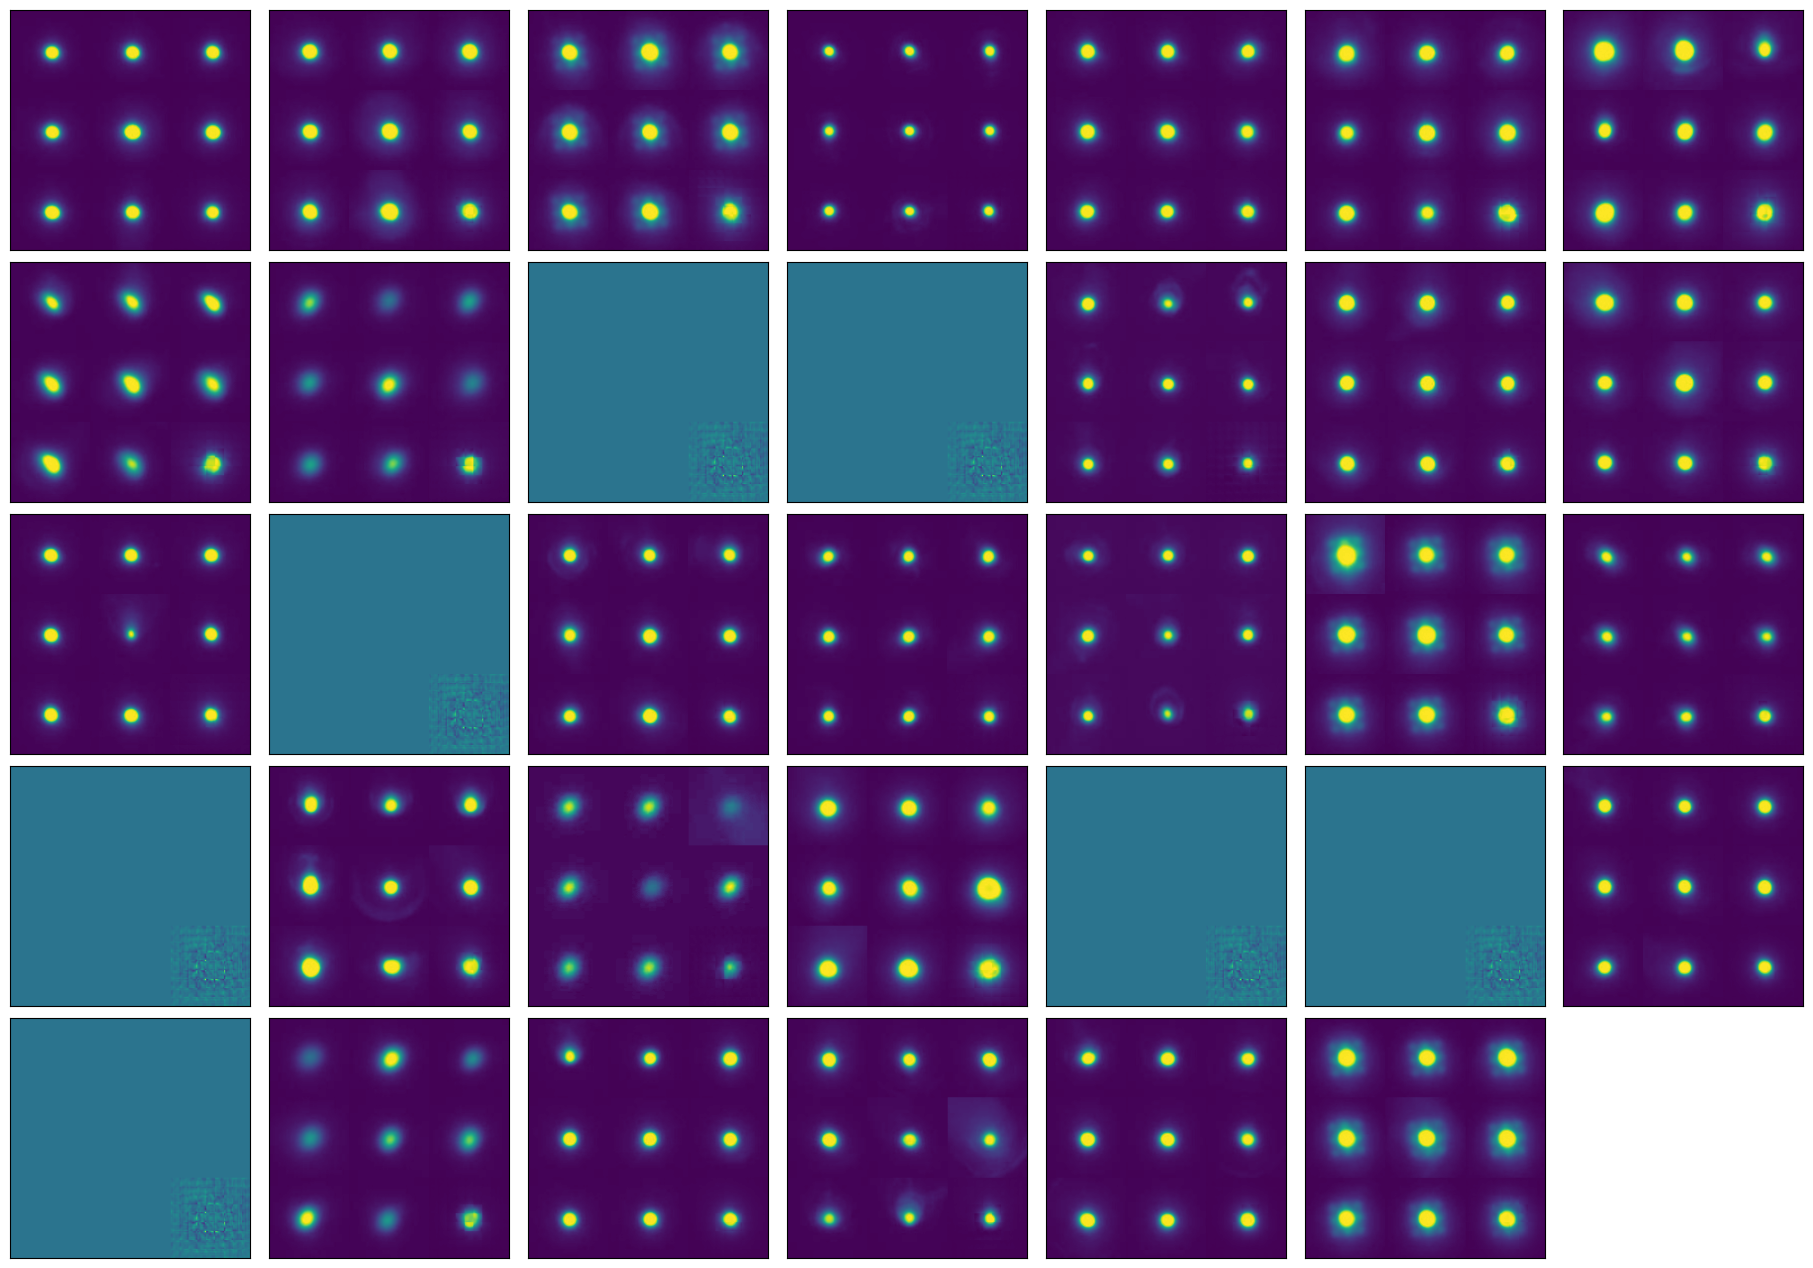

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

# MAEの出力そのままを可視化する場合
#imgs = rec_img

# マスクしていた部分は元の画像を用いる
imgs = rec_img * mask + x * (1 - mask)
imgs = (imgs.data + 1) / 2  # 標準化した状態から0-1に戻す
i = 0
batch_size=34
for img in imgs[:batch_size]:
    #print(img)
    #img  = np.expand_dims(img,0)
    #print(img.shape)
    #print(np.transpose(torch.squeeze(img).numpy()).shape)
    # 出力が線形変換のため0-1になっているとは限らないためclipする
    img = np.clip(np.transpose(img, (1,2,0)), 0, 1)#torch.squeeze(img).numpy(), (1,2,0)), 0, 1) #(C,H,W) -> (H,W,C)
    ax = fig.add_subplot(6,7, i+1, xticks=[], yticks=[])
    ax.imshow(img)
    i += 1

#Raw img

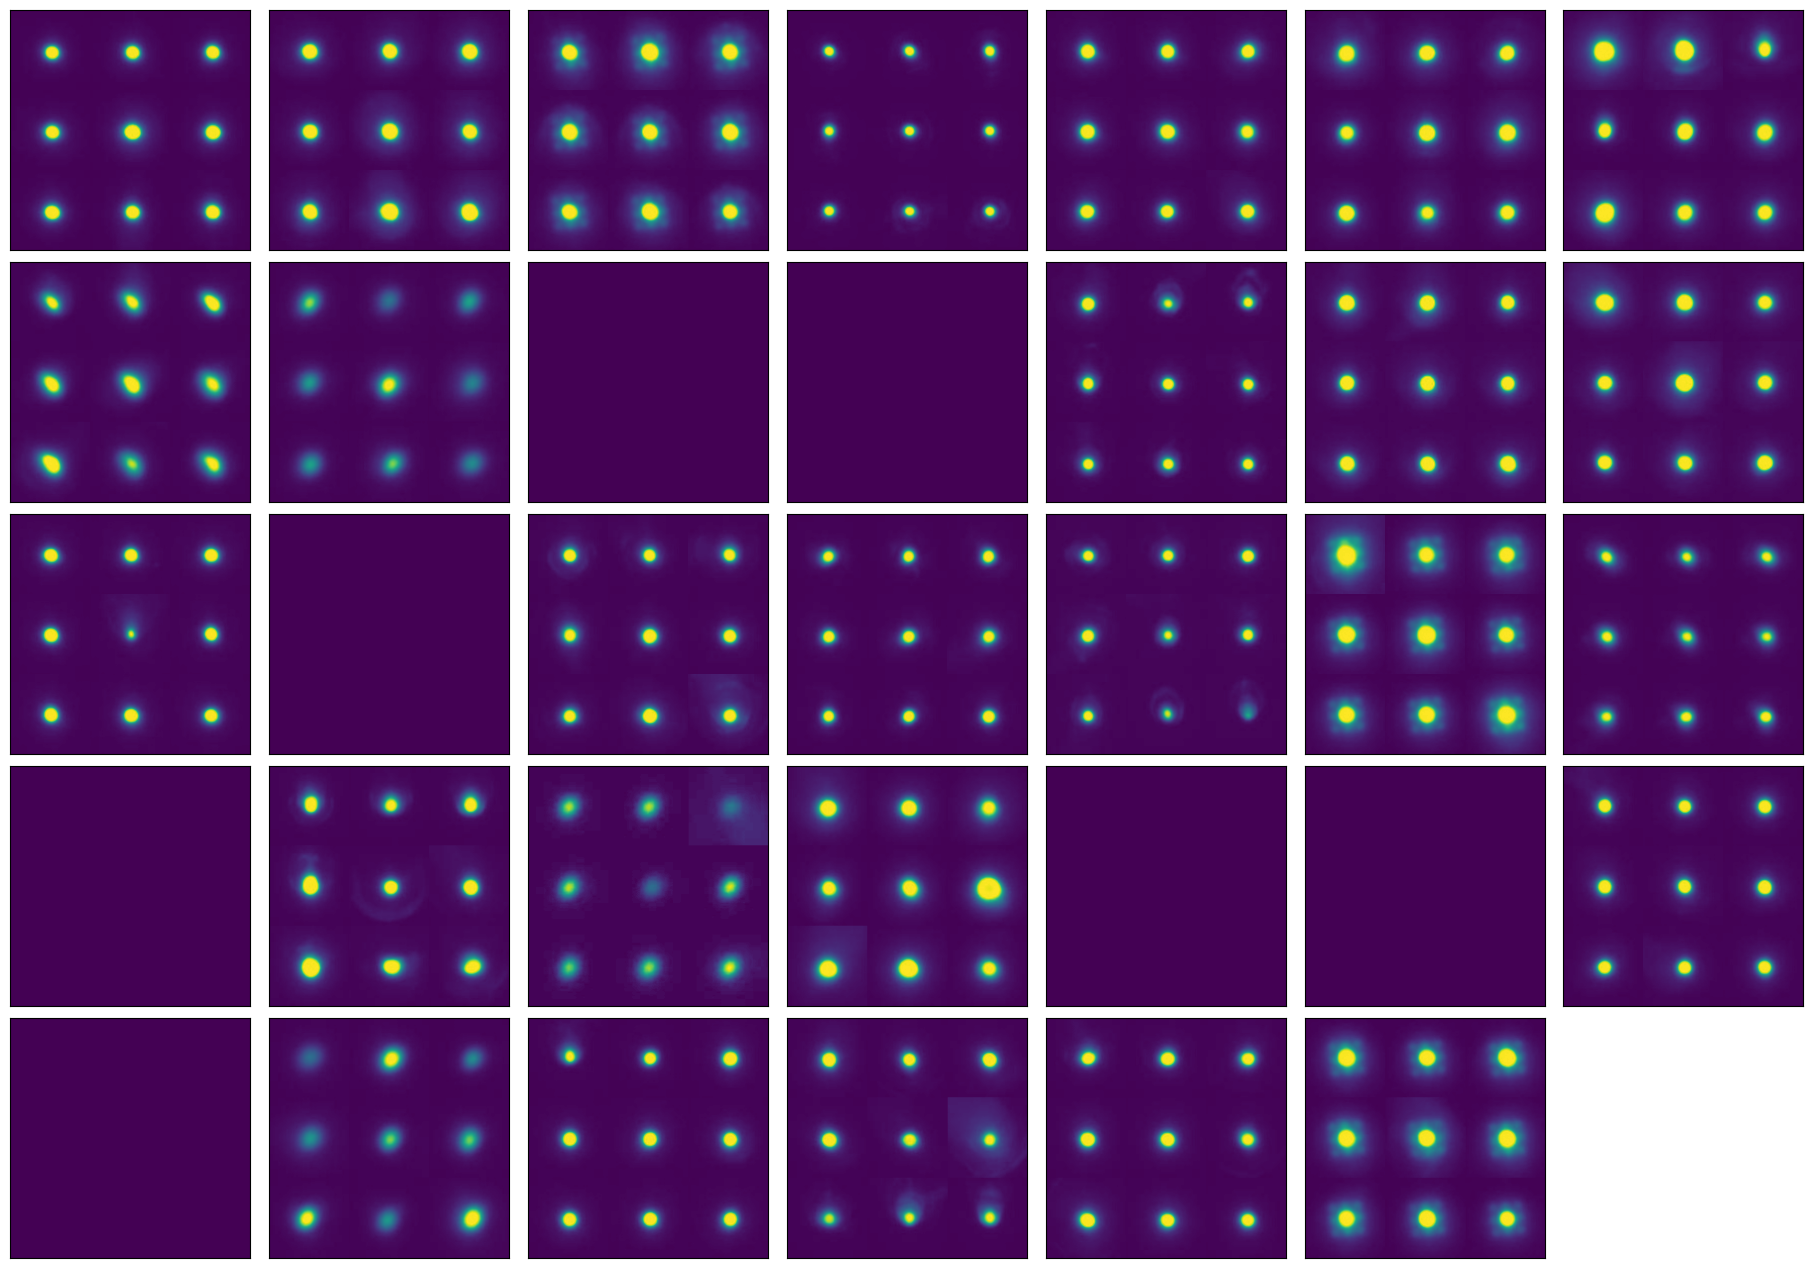

In [46]:
fig = plt.figure(figsize=(18, 30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
imgs = (x.data + 1) / 2
for img in imgs[:batch_size]:
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (0,1)), 0, 1)
    ax = fig.add_subplot(6, 7, i+1, xticks=[], yticks=[])
    ax.imshow(img)
    i += 1

#Difference between original one and reconstructed img

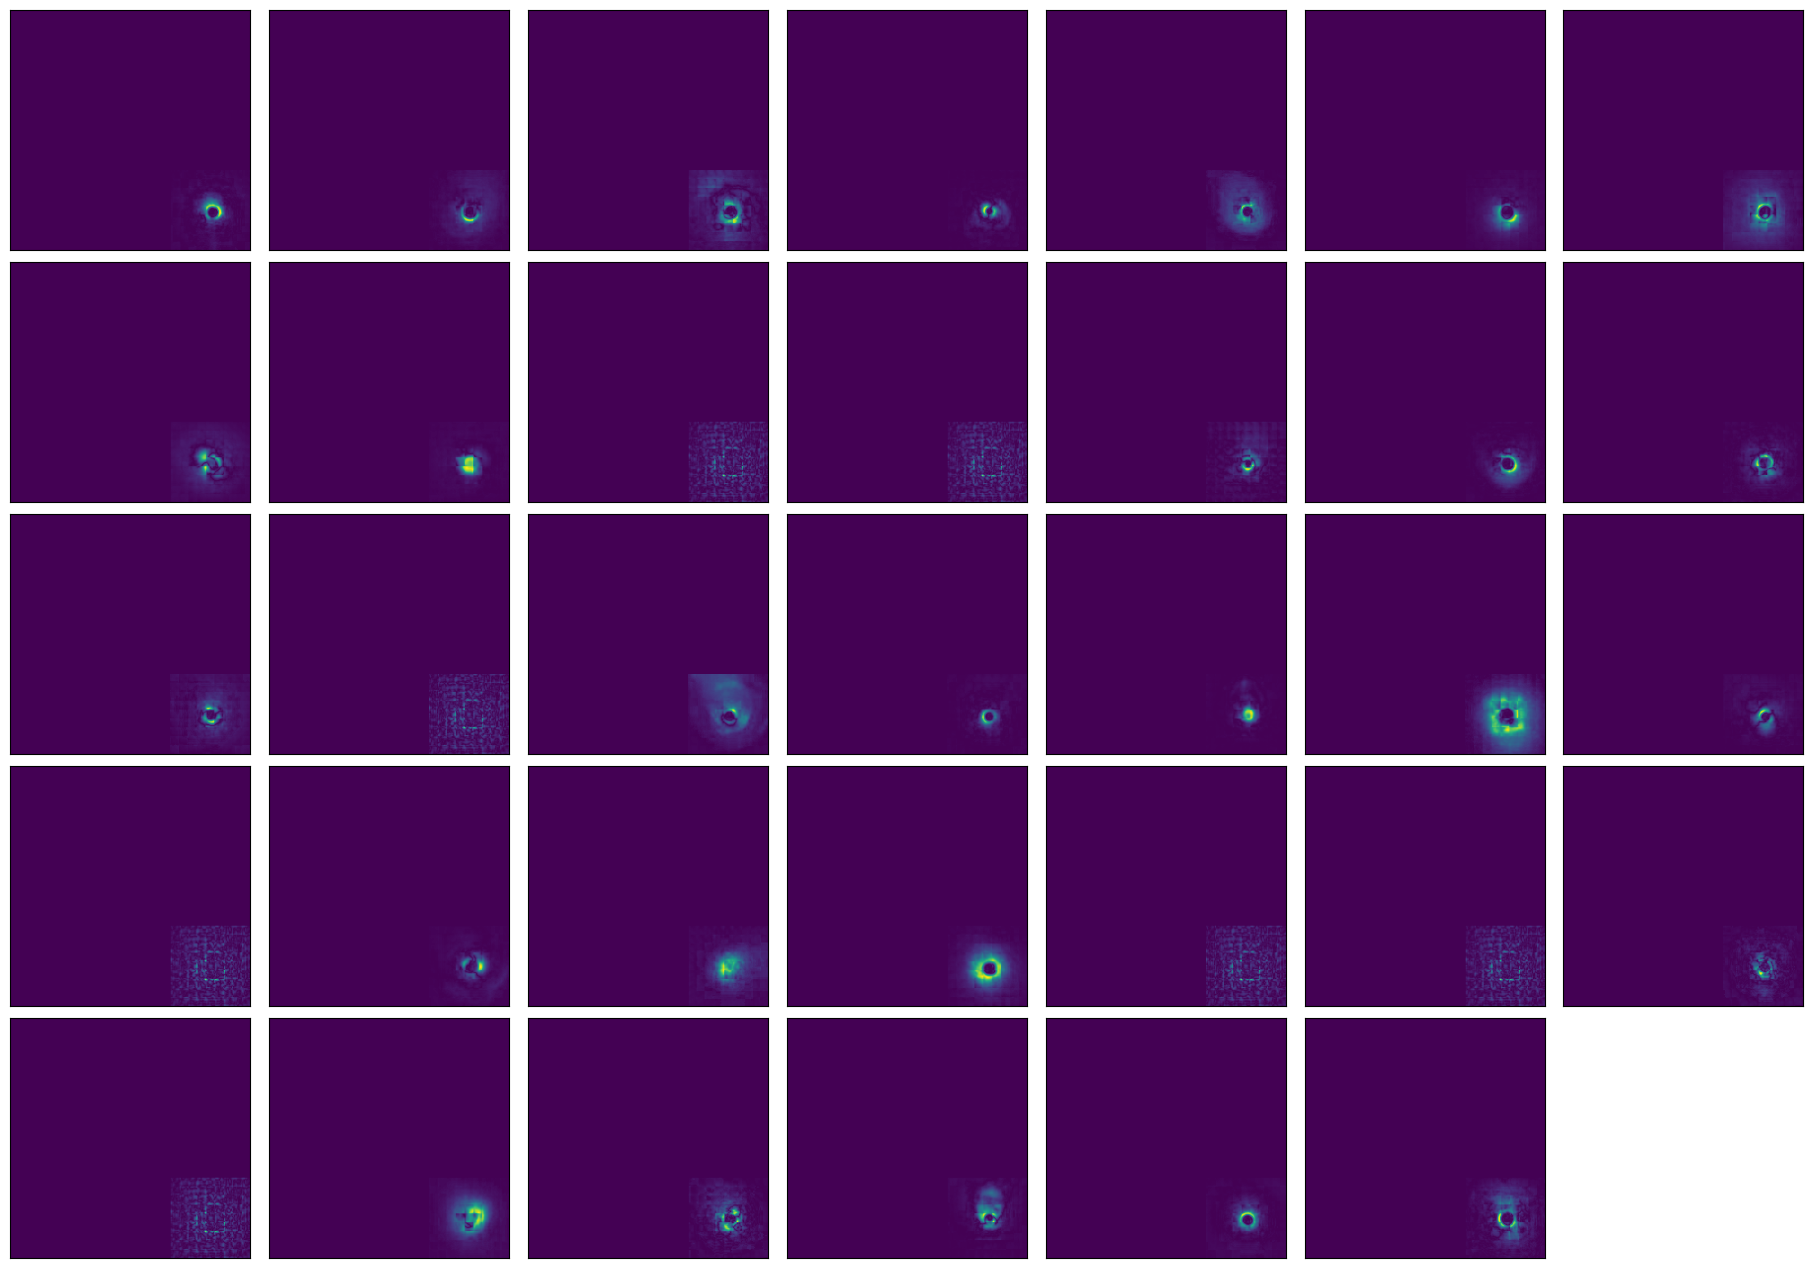

In [47]:
fig = plt.figure(figsize=(18, 30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

# MAEの出力そのままを可視化する場合
#imgs = rec_img

# マスクしていた部分は元の画像を用いる
imgs = rec_img * mask + x * (1 - mask)
imgs = (imgs.data + 1) / 2  # 標準化した状態から0-1に戻す
imgs_original = (x.data + 1) / 2
i = 0
for img,original in zip(imgs[:batch_size],imgs_original[:batch_size]):
    #img  = np.expand_dims(img,0)
    #print(img.shape)
    #print(np.transpose(torch.squeeze(img).numpy()).shape)
    # 出力が線形変換のため0-1になっているとは限らないためclipする
    img = np.clip(np.transpose(img, (1,2,0)), 0, 1)#torch.squeeze(img).numpy(), (1,2,0)), 0, 1) #(C,H,W) -> (H,W,C)
    original = np.clip(np.transpose(original, (1,2,0)), 0, 1)
    dif = abs(img - original)
    ax = fig.add_subplot(6, 7, i+1, xticks=[], yticks=[])
    ax.imshow(dif)
    i += 1

## evaluation metrics for reconstructing accuracy

## Class version

In [48]:
import os
class EvaluateFrameEstimation():
    def __init__(self,test_dl,maskThreshold=60,graphYmax=150,
                 model=model,pretrainedModel=r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\vit\mae_spatterframereconstruction_patch27_27_emb512_700.pth",
                 saveDir=r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\mae",
                 debug=False):
        self.test_dl = test_dl # evaluation img data
        self.maskThreshold = maskThreshold
        self.saveDir=saveDir
        if not os.path.exists(saveDir):
            os.makedirs(saveDir)
        self.debug = debug
        self.graphYmax = graphYmax #grapg range in y

        #inference
        model.load_state_dict(torch.load(pretrainedModel, map_location=device))
        model.eval()
        x = next(iter(test_dl))
        with torch.no_grad():
            rec_img, mask = model(x.to(device))

        self.x, self.rec_img, self.mask = x.to("cpu"), rec_img.to("cpu"), mask.to("cpu")

        #evaluation
        self.evaluation()

    def calculateDifference(self,img):
        img = np.array(img).flatten() #flatten img
        countIteration = 0
        print(img.shape)
        mean = round(img.mean(),1) #mean
        std = round(np.std(img),1) #standard deviation
        return mean, std

    def evaluation(self):
        # マスクしていた部分は元の画像を用いる
        imgs = self.rec_img * self.mask + self.x * (1 - self.mask)
        imgs = np.array(255*((imgs.data + 1) / 2),np.uint8) #0~255
        imgs_original = np.array(255*((self.x.data + 1) / 2),np.uint8) #original image
        i = 1 #iteraion count
        Means = [] #mean difference for estimation accuracy
        Stds = [] #standard deviation for estimation accuracy
        counter = 0
        for img,original in zip(imgs[:batch_size],imgs_original[:batch_size]):
            #img  = np.expand_dims(img,0)
            #print(img.shape)
            #print(np.transpose(torch.squeeze(img).numpy()).shape)
            # 出力が線形変換のため0-1になっているとは限らないためclipする
            #print(img)
            #img  = np.expand_dims(img,0)
            #print(img.shape)
            #print(np.transpose(torch.squeeze(img).numpy()).shape)
            # 出力が線形変換のため0-1になっているとは限らないためclipする
            #img = np.clip(np.transpose(img, (1,2,0)), 0, 1)#torch.squeeze(img).numpy(), (1,2,0)), 0, 1) #(C,H,W) -> (H,W,C)
            #exclude non laser dateset
            if counter!= 9 or counter!=10 or counter!=15 or counter!=21 or counter!=25 or counter!=26 or counter!=28:
                original = original[:,162:,162:] #crop img
                img = img[:,162:,162:]
                original = np.transpose(original,(1,2,0))
                img = np.transpose(img,(1,2,0))
                ret,threshMask = cv2.threshold(original,self.maskThreshold,255,cv2.THRESH_BINARY) #img element should be unsigned int8 or float
                #find contours
                contours, hierarchy = cv2.findContours(np.array(threshMask,dtype=np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


                Area = []
                #detect laser area
                if (bool(contours)==True):
                    #面積(px*px)
                    countContour=1
                    displayImg = original.copy()
                    for j in contours:
                        area = cv2.contourArea(j)
                        Area.append(area)
                        countContour+=1
                        if self.debug:
                            cv2.drawContours(displayImg,j,contourIdx=-1,color=(20*countContour,0,0),thickness=2)
                            cv2.imwrite(f"contours_{i}.jpg",displayImg)

                    if Area:
                        ind = np.argmax(Area)
                        cnt = contours[ind]

                    maxArea = np.max(Area)
                    print(maxArea)
                    dif = abs(img - original)
                    cv2.bitwise_and(dif, threshMask)
                    mean,std = self.calculateDifference(dif)
                    Means.append(mean)
                    Stds.append(std)
                    print(f"{i}'s imgs mean difference : {mean}, std : {std}\n")
                    if self.debug:
                        cv2.imwrite(os.path.join(self.saveDir,f"{i}_dif.jpg"),dif)
                    i+=1

        Means = np.array(Means)
        Stds = np.array(Stds)
        averageDiff = round(Means.mean(),1)
        averageStd = round(np.mean(Stds),1)

        fig,ax = plt.subplots(2,1,figsize=(10,10))
        ax[0].plot(Means,label=f"mean difference = {averageDiff}")
        ax[0].set_ylim(0,self.graphYmax)
        ax[0].legend()
        ax[1].plot(Stds,label=f"mead std = {averageStd}")
        ax[1].set_ylim(0,self.graphYmax)
        ax[1].legend()
        fig.show()
        fig.savefig(os.path.join(self.saveDir,"estimationEvaluation.jpg"))


        print(f"average difference : {averageDiff}, average std : {averageStd}\n")

In [ ]:
# ハイパーパラメータの設定
config = {
    "image_size": [243, 243],
    "patch_size": [9, 9],
    "emb_dim": 384,#192,
    "enc_layers": 12, #12
    "enc_heads": 6,#3
    "enc_dim_head": 64,#64
    "enc_mlp_dim": 384,#192,
    "dec_layers": 4,
    "dec_heads": 6,#3
    "dec_dim_head": 64,
    "dec_mlp_dim":384,#192,
    "mask_ratio": 1/9,
    "dropout": 0.
}

306.5
(6561,)
1's imgs mean difference : 66.5, std : 109.3

457.5
(6561,)
2's imgs mean difference : 213.5, std : 87.5

457.5
(6561,)
3's imgs mean difference : 26.0, std : 67.8

137.5
(6561,)
4's imgs mean difference : 65.1, std : 109.0

302.5
(6561,)
5's imgs mean difference : 151.9, std : 122.1

357.5
(6561,)
6's imgs mean difference : 12.2, std : 32.3

386.0
(6561,)
7's imgs mean difference : 10.4, std : 23.8

494.0
(6561,)
8's imgs mean difference : 27.4, std : 67.9

221.0
(6561,)
9's imgs mean difference : 25.1, std : 64.0

174.5
(6561,)
10's imgs mean difference : 66.6, std : 109.1

374.5
(6561,)
11's imgs mean difference : 113.6, std : 123.8

346.0
(6561,)
12's imgs mean difference : 31.2, std : 79.2

265.5
(6561,)
13's imgs mean difference : 11.3, std : 42.5

314.0
(6561,)
14's imgs mean difference : 222.2, std : 73.1

223.5
(6561,)
15's imgs mean difference : 39.3, std : 89.1

118.0
(6561,)
16's imgs mean difference : 41.1, std : 89.3

1217.5
(6561,)
17's imgs mean difference

C:\Users\Furukawa\AppData\Local\Temp\ipykernel_18004\786261295.py:108: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


average difference : 78.7, average std : 81.9



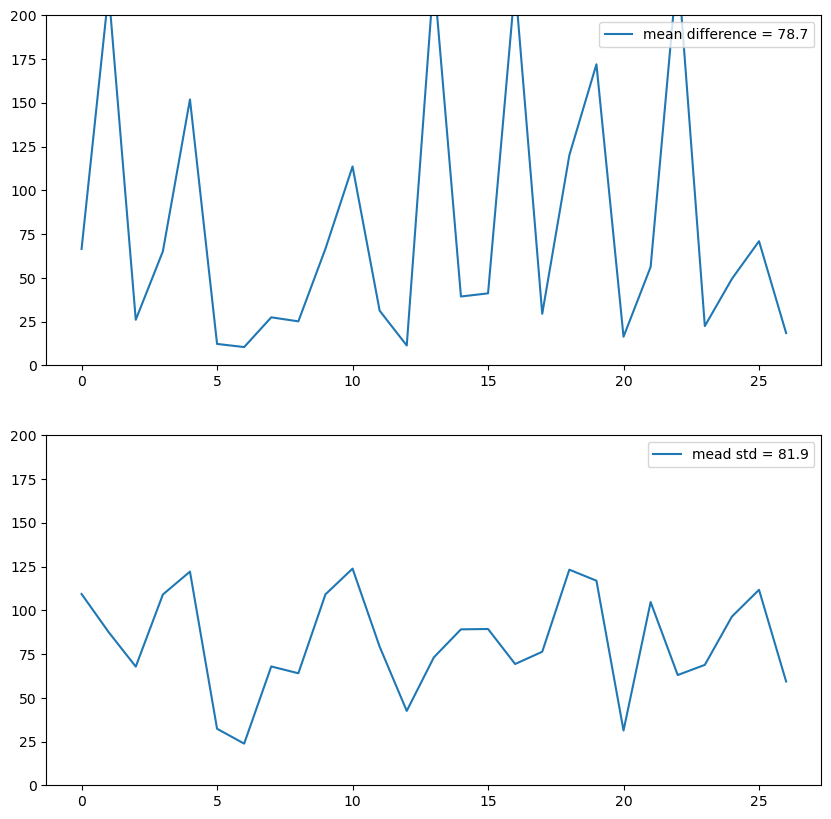

In [49]:

model = MAE_ViT(**config).to(device)

evaluation = EvaluateFrameEstimation(test_dl=test_dl,maskThreshold=70,graphYmax=200,
                                    model=model,pretrainedModel=r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\vit\mae_spatterframereconstruction_patch27_27_emb384_2500.pth",
                                    saveDir =r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\mae\patches27_27\emb384_epoch2500",
                                    debug=True)

## Function version

In [89]:
def calculateDifference(img):
    img = np.array(img).flatten() #flatten img
    countIteration = 0
    while (countIteration<img.shape[0]):
        if img[countIteration] == 0:
            img = np.delete(img,countIteration)
        countIteration+=1
    print(img.shape)
    mean = round(img.mean(),1) #mean
    std = round(np.std(img),1) #standard deviation
    return mean, std

In [ ]:
threshold = 50
x = next(iter(test_dl))
x = x.to("cpu")
rec_img = rec_img.to("cpu")
# マスクしていた部分は元の画像を用いる
imgs = rec_img * mask + x * (1 - mask)
imgs = np.array(255*((imgs.data + 1) / 2),np.uint8) #0~255
imgs_original = np.array(255*((x.data + 1) / 2),np.uint8) #original image
i = 1
Means = []
Stds = []
for img,original in zip(imgs[:batch_size],imgs_original[:batch_size]):
    #img  = np.expand_dims(img,0)
    #print(img.shape)
    #print(np.transpose(torch.squeeze(img).numpy()).shape)
    # 出力が線形変換のため0-1になっているとは限らないためclipする
    #print(img)
    #img  = np.expand_dims(img,0)
    #print(img.shape)
    #print(np.transpose(torch.squeeze(img).numpy()).shape)
    # 出力が線形変換のため0-1になっているとは限らないためclipする
    #img = np.clip(np.transpose(img, (1,2,0)), 0, 1)#torch.squeeze(img).numpy(), (1,2,0)), 0, 1) #(C,H,W) -> (H,W,C)
    original = original[:,162:,162:] #crop img
    img = img[:,162:,162:]
    original = np.transpose(original,(1,2,0))
    img = np.transpose(img,(1,2,0))
    print(original.shape)
    print(img.shape)
    ret,threshMask = cv2.threshold(original,threshold,255,cv2.THRESH_BINARY) #img element should be unsigned int8 or float
    #find contours
    contours, hierarchy = cv2.findContours(np.array(threshMask,dtype=np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    Area = []
    #detect laser area
    if (bool(contours)==True):
        #面積(px*px)
        countContour=1
        displayImg = original.copy()
        for j in contours:
            cv2.drawContours(displayImg,j,contourIdx=-1,color=(20*countContour,0,0),thickness=2)
            area = cv2.contourArea(j)
            Area.append(area)
            countContour+=1
        cv2.imwrite(f"contours_{i}.jpg",displayImg)

        if Area:
            ind = np.argmax(Area)
            cnt = contours[ind]

        maxArea = np.max(Area)
        print(maxArea)
        dif = abs(img - original)
        cv2.bitwise_and(dif, threshMask)
        mean,std = calculateDifference(dif)
        Means.append(mean)
        Stds.append(std)
        print(f"{i}'s imgs mean difference : {mean}, std : {std}\n")
        cv2.imwrite(f"{i}.jpg",dif)
        i+=1

Means = np.array(Means)
Stds = np.array(Stds)
averageDiff = round(Means.mean(),1)
averageStd = round(np.mean(Stds),1)

fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(Means,label=f"mean difference = {averageDiff}")
ax[0].set_ylim(0,100)
ax[0].legend()
ax[1].plot(Stds,label=f"mead std = {averageStd}")
ax[1].set_ylim(0,100)
ax[1].legend()
fig.show()


print(f"average difference : {averageDiff}, average std : {averageStd}\n")

In [44]:
threshold = 50
x = next(iter(test_dl))
x = x.to("cpu")
batch_size=34
imgs = np.array(255*((x.data + 1) / 2),np.uint8) #0~255
count=1
for img in imgs[:batch_size]:
    #print(img)
    #img  = np.expand_dims(img,0)
    #print(img.shape)
    #print(np.transpose(torch.squeeze(img).numpy()).shape)
    # 出力が線形変換のため0-1になっているとは限らないためclipする
    #img = np.clip(np.transpose(img, (1,2,0)), 0, 1)#torch.squeeze(img).numpy(), (1,2,0)), 0, 1) #(C,H,W) -> (H,W,C)
    img = np.transpose(img,(1,2,0))
    print(type(img))
    ret,thresh = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY) #img element should be unsigned int8 or float
    #find contours
    contours, hierarchy = cv2.findContours(np.array(thresh,dtype=np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    Area = []
    #detect laser area
    if (bool(contours)==True):
        #面積(px*px)
        for j in contours:
            area = cv2.contourArea(j)
            Area.append(area)

        if Area:
            ind = np.argmax(Area)
            cnt = contours[ind]

        maxArea = np.max(Area)
    cv2.imwrite(f"{count}.jpg",thresh)
    count+=1

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [30]:
#dif img : area(dir>threshold)
#dif img : sum(dif)/total/255/laser area

#Visualize attention map

torch.Size([1, 243, 243])


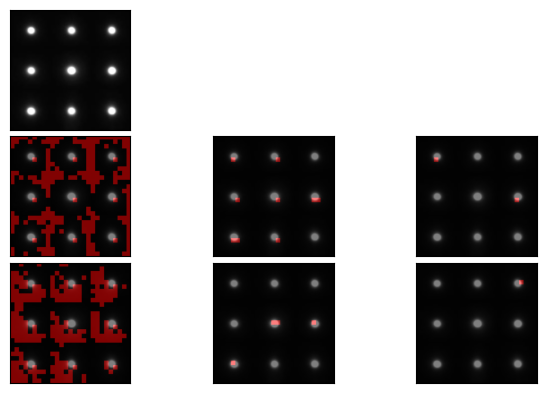

In [51]:
def display_attn_map(model, x):
    # Encoderの最後のattention mapを取得
    attn = model.get_last_selfattention(x[0].unsqueeze(0).to(device))

    # Nはパッチの数
    # (1, num_head, N+1, N+1) -> (num_head, N)
    num_head = config["enc_heads"]
    attn = attn[0, :, 0, 1:].reshape(num_head, -1)  # cls tokenに対するスコアを抽出

    val, idx = torch.sort(attn)  # スコアを昇順でソート
    val /= torch.sum(val, dim=1, keepdim=True)  # スコアを[0-1]で正規化する

    # 累積和をとりスコアの合計が0.6ほどになるように残す
    cumval = torch.cumsum(val, dim=1)
    attn = cumval > (1 - 0.4)
    backward_indexes = torch.argsort(idx)

    # ソートしたものを戻す
    for head in range(num_head):
        attn[head] = attn[head][backward_indexes[head]]

    # スコアを画像の形にする
    w_featmap, h_featmap = config["image_size"][0] // config["patch_size"][0], config["image_size"][1] // config["patch_size"][1]
    attn = attn.reshape(num_head, h_featmap, w_featmap).float()

    # 入力画像と同じ大きさにする
    attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=config["patch_size"][0], mode="nearest")[0].detach().cpu().numpy()

    # 入力画像とヘッドごとのattention mapを出力する
    fig = plt.figure(figsize=(6, 10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                        wspace=0.05)

    img = (x[0].data + 1) / 2
    print(img.shape)
    img = np.array(img)
    img = img.transpose(1,2,0) #[Channel, H,W] -> [H,W,Channel]
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    #img = np.clip(np.transpose(torch.squeeze(img).numpy(), (0,1)), 0, 1) #gray scale
    img = np.clip(img,0,1)
    ax = fig.add_subplot(4, 3, 1, xticks=[], yticks=[])
    ax.imshow(img)

    for i in range(len(attn)):
        featmap = attn[i]
        featmap = np.concatenate((featmap[:,:,np.newaxis], np.zeros((243, 243, 2))), axis=2)
        ax = fig.add_subplot(4, 3, i+4, xticks=[], yticks=[])
        ax.imshow(img)
        ax.imshow(featmap, alpha=0.5)


model = MAE_ViT(**config).to(device)
model.load_state_dict(torch.load(r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\vit\mae_spatterframereconstruction_patch27_27_emb384_2500.pth", map_location=device))
model.eval()
for _ in range(10):
    x= next(iter(test_dl))  # 検証用データからデータを取得する

display_attn_map(model, x)

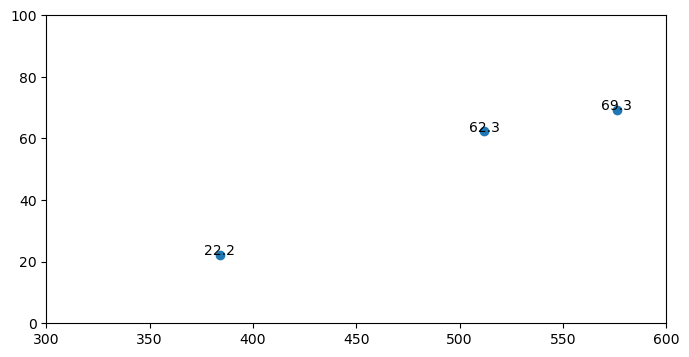

In [63]:
def add_value_label(x_list,y_list):
    x_num =len(x_list)
    for i in range(0, x_num):
        plt.text(x_list[i],y_list[i], y_list[i], ha='center') 
               #(x座標,y座標,表示するテキスト)

plt.figure(figsize=(8,4))
x=[384,512,576]
y=[22.2,62.3,69.3]
yError=[54.5,78.6,89.1]
#plt.errorbar(x, y, yerr = yError, capsize=5, fmt='o', markersize=5, ecolor='black', markeredgecolor = "black", color='w',linestyle="--")
plt.plot(x,y,marker="o",linewidth=0)
add_value_label(x,y)
plt.xlim(300,600)
plt.ylim(0,100)
plt.show()

#ViT classifier

In [35]:
class ViT_Classifier(nn.Module):
    def __init__(self, encoder: MAE_Encoder, num_classes=10):
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = patches + self.pos_embedding  # positional embedding

        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        features = self.layer_norm(self.transformer(patches))
        logits = self.head(features[:, 0])  # cls tokenのみを入力する
        return logits

    def get_last_selfattention(self, x):
        patches = self.patchify(x)
        patches = patches + self.pos_embedding

        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        for i, block in enumerate(self.transformer):
            if i < len(self.transformer) - 1:
                patches = block(patches)
            else:
                return block(patches, return_attn=True)

#ViT Classification

In [37]:
# ハイパーパラメータの設定
config = {
    "image_size": [240, 240],
    "patch_size": [80, 80],
    "emb_dim": 384,#192,
    "enc_layers": 12,#9,
    "enc_heads": 6,#3
    "enc_dim_head": 64,
    "enc_mlp_dim": 576,#192,
    "dec_layers": 4,
    "dec_heads": 6,#3
    "dec_dim_head": 64,
    "dec_mlp_dim": 384,#192,
    "mask_ratio": 1/9,
    "dropout": 0.
}

device = "cuda" if torch.cuda.is_available() else "cpu"
pretrained_model = MAE_ViT(**config).to(device)
pretrained_model.load_state_dict(torch.load(r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\vit\MAE_pretrain_params_emb384_head12_20000.pth", map_location=device))

encoder = pretrained_model.encoder #mae.encoder#pretrained_model.encoder

# モデルの定義
model = ViT_Classifier(encoder).to(device)

epochs = 1000
lr = 0.01#0.0005
warmup_length = 100
batch_size = 64
optimizer = optim.AdamW(model.head.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.05)  # 分類器部分のみ学習
scheduler = CosineScheduler(epochs, lr, warmup_length)
criterion = nn.CrossEntropyLoss()

#Load data

In [38]:
WIDTH =int(IMG_SIZE * SCALE_X)
HEIGHT = int(IMG_SIZE * SCALE_Y)

class Process(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train,width = WIDTH, height = HEIGHT):
        self.x_train = x_train#.reshape(-1,1,width,height)#.astype('float32') / 255
        self.t_train = t_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(self.t_train[idx], dtype=torch.long)

train_data = Process(img_train, label_train)
valid_data = Process(img_valid, label_valid)
test_data = Process(img_test,label_test)

In [39]:
BATCH_SIZE = 64

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [40]:
count = 0
for t,x in dataloader_train:
    print(t.shape)
    print(x.shape)
    if count == 1:
        break
    count += 1

torch.Size([64, 1, 240, 240])
torch.Size([64])
torch.Size([64, 1, 240, 240])
torch.Size([64])


#Trainer

In [42]:
step_count = 0
losses = []
val_losses = []
accuracies = []
val_accuracies = []
for epoch in range(epochs):
    new_lr = scheduler(epoch)
    set_lr(new_lr, optimizer)

    total_train_loss = 0.
    total_train_acc = 0.
    total_valid_loss = 0.
    total_valid_acc = 0.
    for x, t in dataloader_train:
        step_count += 1
        x, t = x.to(device), t.to(device)
        pred = model(x)

        train_loss = criterion(pred, t)
        train_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()
        total_train_acc += train_acc
    losses.append(total_train_loss/len(dataloader_train))
    accuracies.append(total_train_acc/len(dataloader_train))

    with torch.no_grad():
        for x, t in dataloader_valid:
            x, t = x.to(device), t.to(device)
            pred = model(x)

            valid_loss = criterion(pred, t)
            valid_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()

            total_valid_loss += valid_loss.item()
            total_valid_acc += valid_acc
    val_losses.append(total_valid_loss/len(dataloader_valid))
    val_accuracies.append(total_valid_acc/len(dataloader_valid))
    print(f"Epoch[{epoch+1} / {epochs}]",
          f"Train Loss: {total_train_loss/len(dataloader_train):.4f}",
          f"Train Acc.: {total_train_acc/len(dataloader_train):.4f}",
          f"Valid Loss: {total_valid_loss/len(dataloader_valid):.4f}",
          f"Valid Acc.: {total_valid_acc/len(dataloader_valid):.4f}")

    if epoch %200 == 199:
        torch.save(model.state_dict(), r"C:\Users\Furukawa\Documents\TechAssistant\ML_results\vit\vit__emb384_head12_{}.pth".format(epoch+1))

Epoch[1 / 1000] Train Loss: 1.6558 Train Acc.: 0.6421 Valid Loss: 1.4818 Valid Acc.: 0.6750
Epoch[2 / 1000] Train Loss: 1.2611 Train Acc.: 0.6790 Valid Loss: 1.0674 Valid Acc.: 0.7058
Epoch[3 / 1000] Train Loss: 0.9384 Train Acc.: 0.6722 Valid Loss: 0.8172 Valid Acc.: 0.6767
Epoch[4 / 1000] Train Loss: 0.7684 Train Acc.: 0.6752 Valid Loss: 0.6938 Valid Acc.: 0.6902
Epoch[5 / 1000] Train Loss: 0.6857 Train Acc.: 0.6838 Valid Loss: 0.6395 Valid Acc.: 0.6953
Epoch[6 / 1000] Train Loss: 0.6442 Train Acc.: 0.6862 Valid Loss: 0.6067 Valid Acc.: 0.7062
Epoch[7 / 1000] Train Loss: 0.6217 Train Acc.: 0.6880 Valid Loss: 0.5907 Valid Acc.: 0.7080
Epoch[8 / 1000] Train Loss: 0.6080 Train Acc.: 0.6927 Valid Loss: 0.5775 Valid Acc.: 0.7097
Epoch[9 / 1000] Train Loss: 0.5987 Train Acc.: 0.6918 Valid Loss: 0.5716 Valid Acc.: 0.7132
Epoch[10 / 1000] Train Loss: 0.5927 Train Acc.: 0.6944 Valid Loss: 0.5624 Valid Acc.: 0.7161
Epoch[11 / 1000] Train Loss: 0.5874 Train Acc.: 0.6970 Valid Loss: 0.5565 Valid

#Evaluation

C:\Users\Furukawa\AppData\Local\Temp\ipykernel_18308\907674613.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


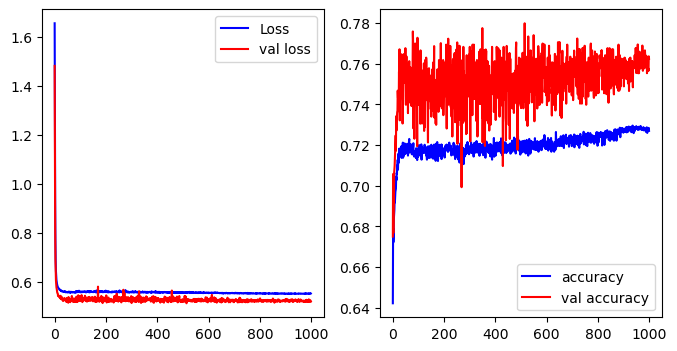

In [43]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(losses,color="b",label="Loss")
ax[0].plot(val_losses,color="r",label="val loss")
#ax[0].set_ylim(0,0.7)
ax[0].legend()
ax[1].plot(accuracies,color="b",label="accuracy")
ax[1].plot(val_accuracies,color="r",label="val accuracy")
#ax[1].set_ylim(0,0.7)
ax[1].legend()
fig.show()

In [44]:
dataloader_test = torch.utils.data.DataLoader(
    test_data,
    shuffle=False,
    batch_size=1
)

In [45]:
total_test_loss = 0.
total_test_acc = 0.
total_spatter_pred = 0
total_spatter_label = 0
true_pred = 0
true_label = 0
with torch.no_grad():
    for x, t in dataloader_test:
        x, t = x.to(device), t.to(device)
        pred = model(x)
        test_loss = criterion(pred, t)
        #print(torch.argmax(pred, dim=1)[0])
        #print(t[0]==torch.argmax(pred, dim=1)[0])
        #predict spatter:
        if torch.argmax(pred,dim=1)[0] == 1:
            if t[0] == 0:
                total_spatter_pred += 1
            elif t[0] == 1:
                total_spatter_pred += 1
                total_spatter_label += 1
                true_pred += 1
        #predict non spatter
        else:
            #false negative
            if t[0] == 1:
                total_spatter_label += 1
        #if torch.arg
        test_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()
        total_test_loss += test_loss.item()
        total_test_acc += test_acc

precision = ((true_pred)/total_spatter_pred)
recall = ((true_pred)/total_spatter_label)
f1 = 2*precision*recall/(precision+recall)
print(f"Test Loss: {total_test_loss/len(dataloader_test):.4f}",f"Test Acc.: {total_test_acc/len(dataloader_test):.4f}",
      f"Test Precision : {precision:.4f}",f"Test Recall : {recall:.4f}",f"Test F-value : {f1:.4f}")

Test Loss: 0.6953 Test Acc.: 0.6506 Test Precision : 0.8957 Test Recall : 0.2694 Test F-value : 0.4142


x#Visualize attention map

In [ ]:
def display_attn_map(model, x):
    # Encoderの最後のattention mapを取得
    attn = model.get_last_selfattention(x[0].unsqueeze(0).to(device))

    # Nはパッチの数
    # (1, num_head, N+1, N+1) -> (num_head, N)
    num_head = config["enc_heads"]
    attn = attn[0, :, 0, 1:].reshape(num_head, -1)  # cls tokenに対するスコアを抽出

    val, idx = torch.sort(attn)  # スコアを昇順でソート
    val /= torch.sum(val, dim=1, keepdim=True)  # スコアを[0-1]で正規化する

    # 累積和をとりスコアの合計が0.6ほどになるように残す
    cumval = torch.cumsum(val, dim=1)
    attn = cumval > (1 - 0.4)
    backward_indexes = torch.argsort(idx)

    # ソートしたものを戻す
    for head in range(num_head):
        attn[head] = attn[head][backward_indexes[head]]

    # スコアを画像の形にする
    w_featmap, h_featmap = config["image_size"][0] // config["patch_size"][0], config["image_size"][1] // config["patch_size"][1]
    attn = attn.reshape(num_head, h_featmap, w_featmap).float()

    # 入力画像と同じ大きさにする
    attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=config["patch_size"][0], mode="nearest")[0].detach().cpu().numpy()

    # 入力画像とヘッドごとのattention mapを出力する
    fig = plt.figure(figsize=(6, 10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                        wspace=0.05)

    img = (x[0].data + 1) / 2
    img = np.clip(np.transpose(torch.squeeze(img).cpu().numpy(), (0,1)), 0, 1)
    ax = fig.add_subplot(2, 3, 1, xticks=[], yticks=[])
    ax.imshow(img)

    for i in range(len(attn)):
        featmap = attn[i]
        featmap = np.concatenate((featmap[:,:,np.newaxis], np.zeros((240, 240, 3))), axis=2)
        ax = fig.add_subplot(2, 3, i+4, xticks=[], yticks=[])
        ax.imshow(img)
        ax.imshow(featmap, alpha=0.5)



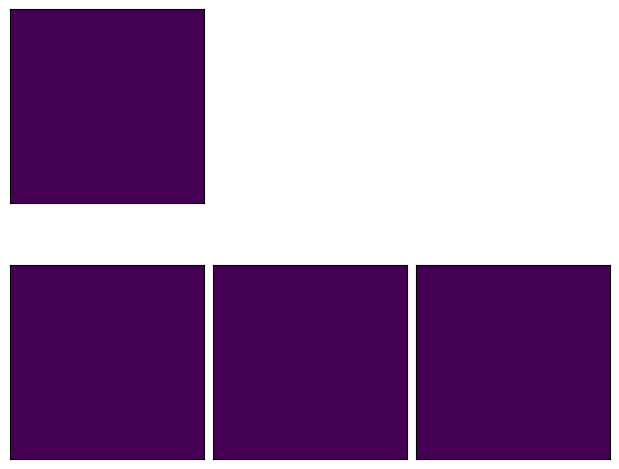

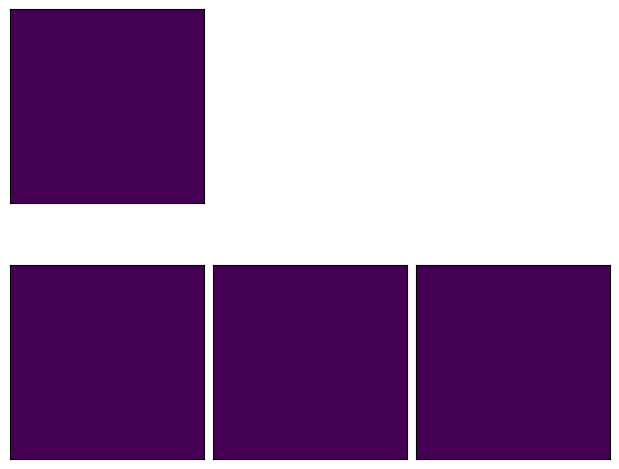

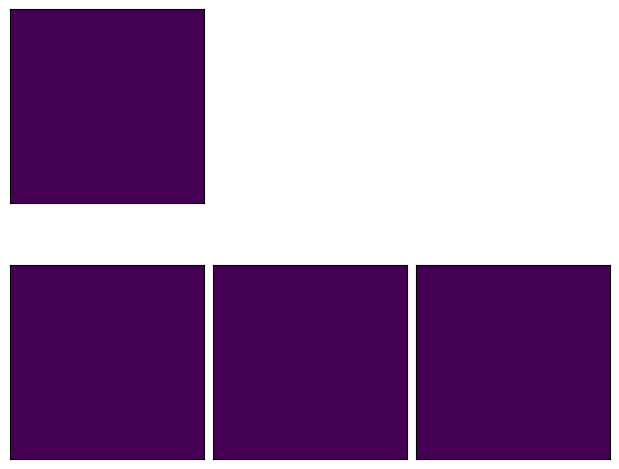

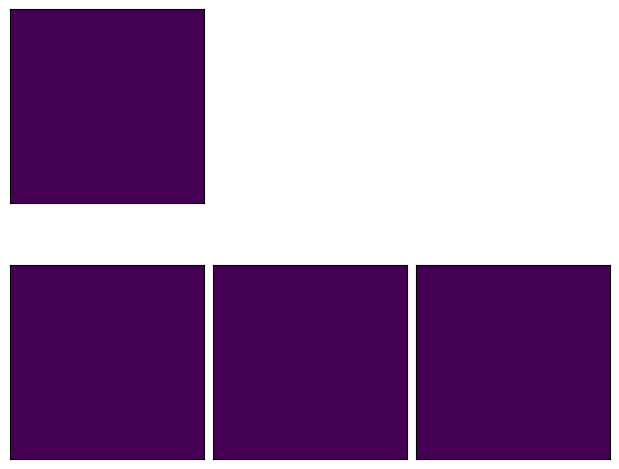

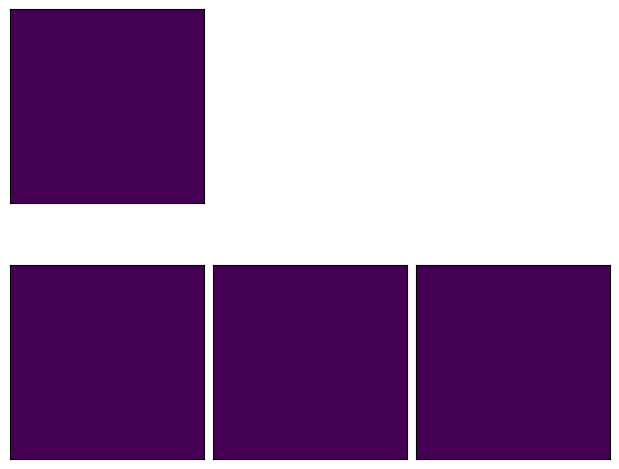

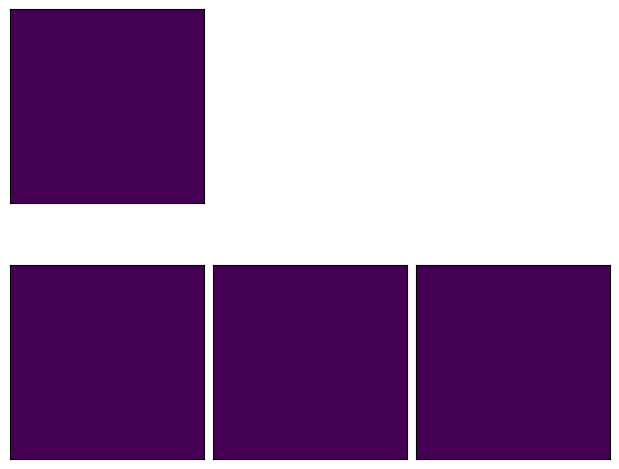

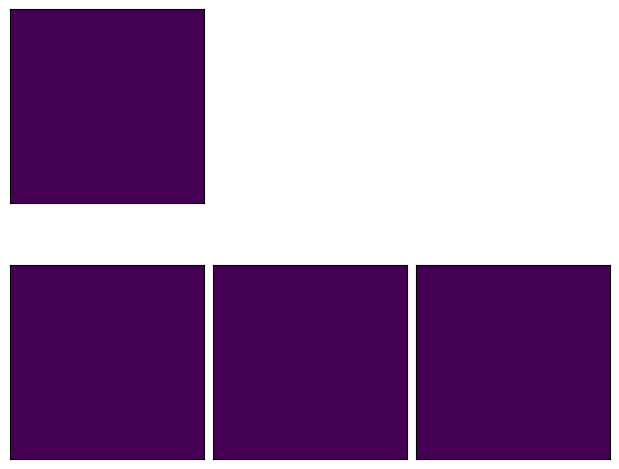

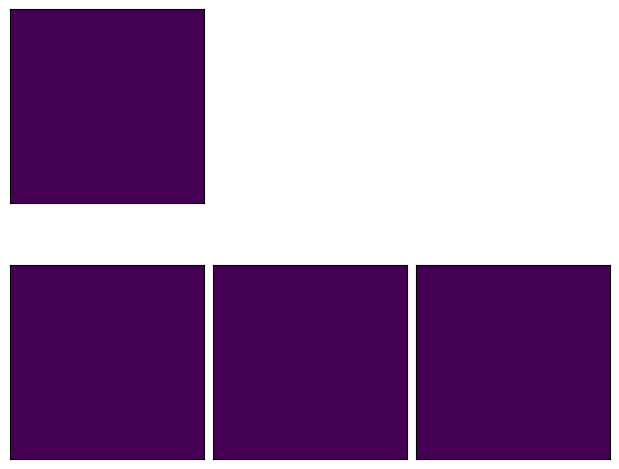

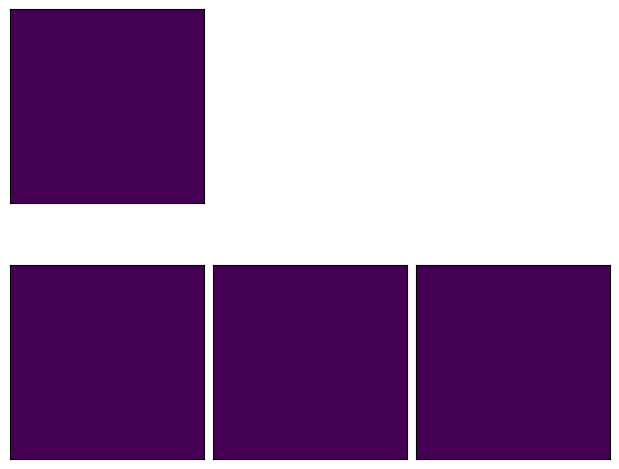

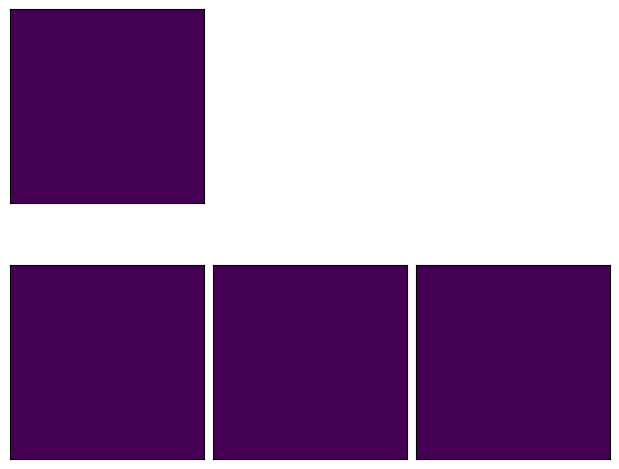

In [ ]:
#mae = MAE_ViT(**config).to(device)
#encoder = mae.encoder

# モデルの定義
#model = ViT_Classifier(encoder).to(device)
#model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Lecture09/model/ViT_supervised_params.pth", map_location=device))
model.eval()
for i in range(100):
    if i %10 == 9:
        x,t = next(iter(dataloader_test))
        display_attn_map(model, x)